# Introduction

In this notebook, we will run a Prototypical Network for Few-Shot learning using 3 pre-trained models (VGG19, ResNet50, & DenseNet121) as the feature extractors.

This is also known as **transfer Learning** - We are going to freeze the model parameters so that there are no updates during backpropagation. This means there is no training, we are going to use weights of the pre-trained model on our eye image data and see how well the model does on a dataset it has not seen before. In other words we are going to run the model on our test data, and see how accurate it is.

## 1. Import relevant packages

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
!pip install torch-summary==1.4.4 # for DenseNet121
from torchsummary import summary

import utilities
import read_data
import prototypical_network
import train_and_evaluation


## 2. Device

In [ ]:
# get the computational device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
import zipfile
import os

# Specify the path to the zip file
zip_file_path = '/content/Disease-Classification-Few-Shot-Learning/selfmade_data.zip'

# Specify the directory where you want to extract the contents
extract_dir = '/content/Disease-Classification-Few-Shot-Learning/'

# Create the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the specified directory
    zip_ref.extractall(extract_dir)

print(f'Contents extracted to {extract_dir}')


Contents extracted to /content/Eye-Disease-Classification-Few-Shot-Learning/


## 3. Get data

We are going to use data in the test set.

In [ ]:
%%time
# we want to resize all our images to 224x224
img_height, img_width = 224, 224
data_dir = "/content/Disease-Classification-Few-Shot-Learning/selfmade_data/test_data"


x_test, y_test = read_data.read_eye_images(data_dir, img_height, img_width, augmentation=False)

CPU times: user 306 ms, sys: 61 ms, total: 367 ms
Wall time: 427 ms


In [ ]:
# check the shape of our data
x_test.shape, y_test.shape

((30, 224, 224, 3), (30,))

## 4. Display example images

Before running a model with any data, you should have a visual inspection of the data first.

Class labels sampled: ['vitiligo' 'eczema' 'keratosis']


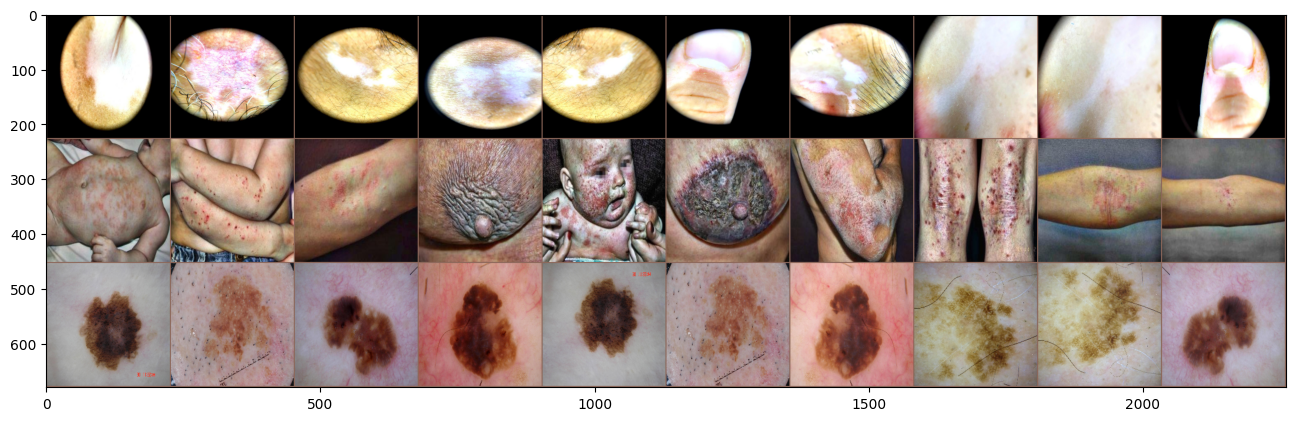

In [ ]:
# As an example, lets pick a sample with the following
n_way = 3     # no. of classes --> Remember due to augmentation we now have 28 classes to sample from
n_support = 7 # no. of support images per class
n_query = 7   # no. of qiery images per class
sample_example = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test) #  returns a dictionary
train_and_evaluation.display_sample(sample_example['images'])
print(f"Class labels sampled: {sample_example['class_labels']}")

## 5. Download pretrained model

In [ ]:
################################# VGG19 ##############################################

vgg19_model = models.vgg19(pretrained=True)

################################# ResNet50 ###########################################

resnet50_model = models.resnet50(pretrained=True)

################################# DenseNet121 ########################################

densenet121_model = models.densenet121(pretrained=True)

**5a. Model architecture**

In [ ]:
################################# VGG19 ###############################################

vgg19_model = vgg19_model.to(device)
print(vgg19_model)

################################ ResNet50 #############################################

resnet50_model = resnet50_model.to(device)
print(resnet50_model)

################################ DenseNet121 ##########################################

densenet121_model = densenet121_model.to(device)
print(densenet121_model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

**5b. Summarize model**

Here you get to understand input and output image sizes as the model extracts features from each image. You also find out the number of parameters in your model

In [ ]:
################################## VGG19 ########################################

summary(vgg19_model, (3, 224, 224), device=device)

################################# ResNet50 #####################################

summary(resnet50_model, (3, 224, 224), device=device)

################################# DenseNet121 ##################################

# you need torch-summary==1.4.4 to be able to summarize DenseNet121 model
#!pip install torch-summary==1.4.4
summary(densenet121_model, (3, 224, 244), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 122]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 122]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 122]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 61]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 61]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 61]          45,440
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 61]          49,600
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 61]          53,760
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 61]          57,920
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 61]          62,080
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 61]          66,240
|    └─_Transition: 2-6                  [-1, 128, 28, 30

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 122]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 122]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 122]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 61]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 61]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 61]          45,440
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 61]          49,600
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 61]          53,760
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 61]          57,920
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 61]          62,080
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 61]          66,240
|    └─_Transition: 2-6                  [-1, 128, 28, 30

**5c. Freeze the model**

This stops any parameter updates during backpropagation

In [ ]:
#################################### VGG19 ############################################

for param in vgg19_model.parameters():
  param.requires_grad = False

#################################### ResNet50 #########################################

for param in resnet50_model.parameters():
  param.requires_grad = False

################################### DenseNet121 #########################################

for param in densenet121_model.parameters():
  param.requires_grad = False

**5d. Flatten outputs from the Convolutional base networks and remove the Linear layers**

In [ ]:
###################################### VGG19 ##########################################

vgg19_model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
vgg19_model.classifier = nn.Flatten()
summary(vgg19_model, (3, 224, 224), device=device)

####################################### ResNet50 ######################################

resnet50_model.fc = nn.Flatten()
summary(resnet50_model, (3, 224, 224), device=device)

###################################### DenseNet121 ####################################

densenet121_model.classifier = nn.Flatten()
summary(densenet121_model, (3, 224, 224), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        (128)
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          (45,440)
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          (49,600)
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          (53,760)
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          (57,920)
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          (62,080)
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          (66,240)
|    └─_Transition: 2-6                  

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1024, 7, 7]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        (9,408)
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        (128)
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─_DenseBlock: 2-5                  [-1, 256, 56, 56]         --
|    |    └─_DenseLayer: 3-1             [-1, 32, 56, 56]          (45,440)
|    |    └─_DenseLayer: 3-2             [-1, 32, 56, 56]          (49,600)
|    |    └─_DenseLayer: 3-3             [-1, 32, 56, 56]          (53,760)
|    |    └─_DenseLayer: 3-4             [-1, 32, 56, 56]          (57,920)
|    |    └─_DenseLayer: 3-5             [-1, 32, 56, 56]          (62,080)
|    |    └─_DenseLayer: 3-6             [-1, 32, 56, 56]          (66,240)
|    └─_Transition: 2-6                  

## 6. Test the accuracy of your model

In [ ]:
# Lets test our Prototypical Network Model

prototypical_model = prototypical_network.ProtoNet(densenet121_model, device)
prototypical_model.to(device)

n_way = 3
n_support = 5
n_query = 5

test_episodes = 5000


test_loss, test_accuracy = train_and_evaluation.test_model_on_one_task(prototypical_model, n_way, n_support, n_query, test_episodes, x_test, y_test)

# display the test results
print(f"Average Test Loss: {test_loss:.3f}")
print(f"Average Test Accuracy: {test_accuracy * 100:.2f}%")

Test loss and accuracy every 100 episodes: 
Episode: 0 ---> Loss: 2.239, Accuracy: 0.87
Episode: 100 ---> Loss: -0.000, Accuracy: 1.00
Episode: 200 ---> Loss: 21.068, Accuracy: 0.80
Episode: 300 ---> Loss: 0.000, Accuracy: 1.00
Episode: 400 ---> Loss: -0.000, Accuracy: 1.00
Episode: 500 ---> Loss: -0.000, Accuracy: 1.00
Episode: 600 ---> Loss: 3.097, Accuracy: 0.93
Episode: 700 ---> Loss: 0.791, Accuracy: 0.93
Episode: 800 ---> Loss: -0.000, Accuracy: 1.00
Episode: 900 ---> Loss: 3.573, Accuracy: 0.87
Episode: 1000 ---> Loss: 2.100, Accuracy: 0.93
Episode: 1100 ---> Loss: 0.000, Accuracy: 1.00
Episode: 1200 ---> Loss: 1.386, Accuracy: 0.93
Episode: 1300 ---> Loss: 3.026, Accuracy: 0.93
Episode: 1400 ---> Loss: -0.000, Accuracy: 1.00
Episode: 1500 ---> Loss: 4.672, Accuracy: 0.87
Episode: 1600 ---> Loss: 0.065, Accuracy: 0.93
Episode: 1700 ---> Loss: 0.058, Accuracy: 0.93
Episode: 1800 ---> Loss: 0.000, Accuracy: 1.00
Episode: 1900 ---> Loss: 4.044, Accuracy: 0.93
Episode: 2000 ---> Los

## 7. Make predictions

Class labels sampled: ['vitiligo' 'eczema' 'keratosis']
{'loss': 3.5675089359283447, 'acc': 0.9333333969116211, 'y_hat': tensor([[0, 0, 1, 0, 0],
        [1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2]], device='cuda:0')}


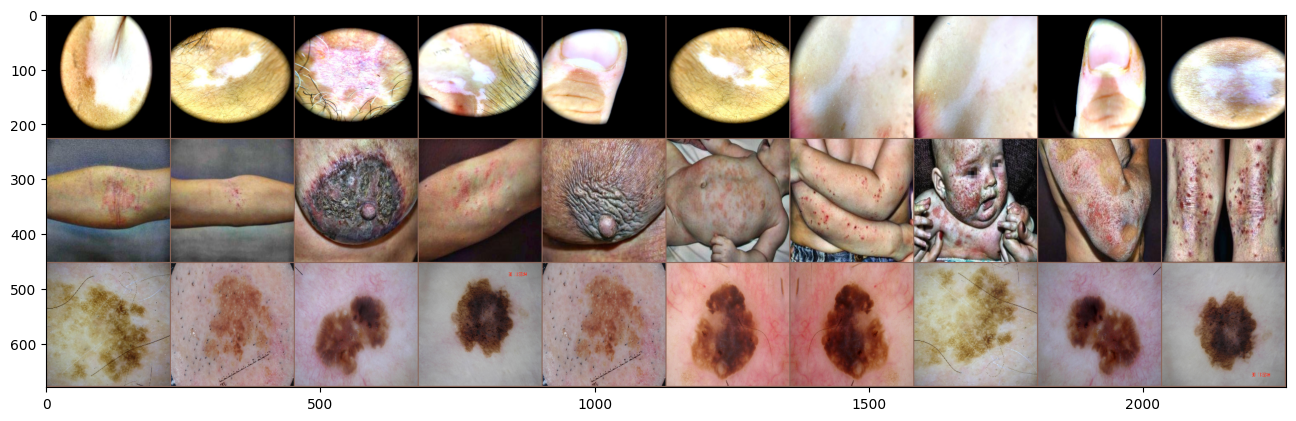

In [ ]:
# Lets ask our model to predict on (n_query) tasks

prototypical_model.to(device)
n_way = 3
n_support = 5
n_query = 5

sample_images = train_and_evaluation.extract_sample(n_way, n_support, n_query, x_test, y_test)

results = train_and_evaluation.predict(prototypical_model, sample_images, device)

# display the sample images used
train_and_evaluation.display_sample(sample_images["images"])

print(f"Class labels sampled: {sample_images['class_labels']}")


# display the test results
print(results)
